In [1]:
%pylab inline

from __future__ import division, print_function

from assist.environment import Atmosphere
from assist.aircraft import Aircraft
from assist.component import Wing, Engine, Payload
from assist.mission import Segment

Populating the interactive namespace from numpy and matplotlib


#Aircraft Sizing, Synthesis and Integration Support Tool (ASSIST)

##References
* Mattingly, J. D., Heiser, W. H., and Daley, D. H., "Aircraft Engine Design," AIAA Education Series, AIAA, New York, NY, 1987.
* Raymer, D. P., "Aircraft Design: A Conceptual Approach," 3rd ed., AIAA Education Series, AIAA, Reston, VA, 1999.
* Roskam, J., "Airplane Design: Part I-VIII." DARcorporation, Lawrence, KS, 2006.

In [2]:
wing = Wing(flap_type='single_slot',
            configuration='landing',
            slats=True,
            k_aero=0.75,
            sweep=30,
            flap_span=[0.2, 0.4],
            taper_ratio=0.2)

wing.takeoff
print("TAKE-OFF CL_max:", wing.cl_max)
wing.landing
print("LANDING CL_max:", wing.cl_max)

TAKE-OFF CL_max: 1.53541158088
LANDING CL_max: 1.54698088235


In [3]:
aircraft = Aircraft(wing=wing,
                    stores=[Payload('Crew', 200),
                            Payload('Cannon', 270),
                            Payload('Ammunition Feed System', 405),
                            Payload('Ammunition', 550),
                            Payload('Casings', 198),
                            Payload('AMRAAMs', 652),
                            Payload('AIM-9Xs', 382)],
                    cd_0=0.02)

tofl = 1500
airfield_altitude = 5000

cruise_altitude = 35000
cruise_range = 500

dash_altitude = 4000
dash_speed = 1500
dash_range = 100

ldgfl = 3500
landing_speed = 150

mission = Mission(segments=[Segment('warmup',
                                    altitude=airfield_altitude,
                                    speed=0,
                                    time=60),
                            Segment('takeoff',
                                    altitude=airfield_altitude,
                                    speed=150,
                                    tofl=tofl,
                                    k_to=1.2,
                                    afterburner=True,
                                    mu_to=0.05,
                                    temperature_sl=100),
                            Segment('climb',
                                    altitude=airfield_altitude,
                                    speed=500),
                            Segment('cruise',
                                    altitude=cruise_altitude,
                                    speed=1050,
                                    range=cruise_range,
                                    release=[()]),
                            Segment('descend',
                                    altitude=dash_altitude,
                                    speed=1000),
                            Segment('dash',
                                    altitude=dash_altitude,
                                    speed=dash_speed,
                                    range=dash_range),
                            Segment('climb',
                                    altitude=cruise_altitude,
                                    speed=1000),
                            Segment('cruise',
                                    altitude=cruise_altitude,
                                    speed=1050,
                                    range=cruise_range),
                            Segment('descend',
                                    altitude=airfield_altitude,
                                    speed=1000),
                            Segment('land',
                                    altitude=airfield_altitude,
                                    speed=landing_speed,
                                    ldgfl=ldgfl)])

In [4]:
aircraft.synthesize(mission)

Segment warmup has a weight fraction of 0.99
Segment takeoff has a weight fraction of 0.98
Segment climb has a weight fraction of 0.95
Segment cruise has a weight fraction of 0.456878837121
Segment descend has a weight fraction of 0.98
Segment dash has a weight fraction of 0.516241523889
Segment climb has a weight fraction of 0.95
Segment cruise has a weight fraction of 0.93795447445
Segment descend has a weight fraction of 0.98
Segment land has a weight fraction of 0.99


[0, 300, 0, 2]

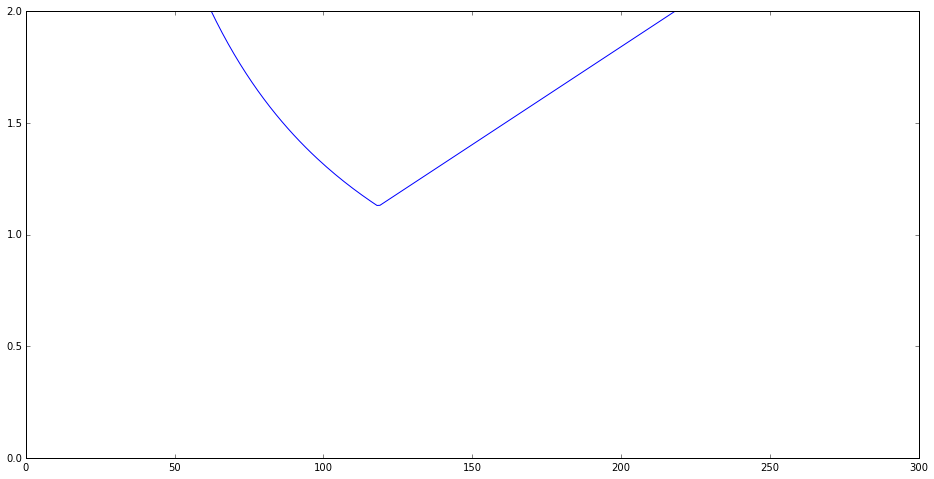

In [5]:
fig = figure(figsize=(16,8))
ax = plot(aircraft.t_to_w_req)
axis([0, 300, 0, 2])

In [6]:
aircraft.fuel_fraction

0.815824625245255

In [7]:
aircraft.size(mission)

In [10]:
aircraft.t_to_w

1.1305671326687288

In [9]:
aircraft.engine.max_thrust

22285.633331611076